
File: Human-aware PPO agent vs Human Keyboard Input 60 sec Cramped Room.json
Episode Length: 404
Total Reward: 120
Soups Delivered: 6
INTERACT counts: Agent 0 = 107, Agent 1 = 34
Reward Events (time step, reward):
  - At step 40: +20
  - At step 101: +20
  - At step 153: +20
  - At step 239: +20
  - At step 315: +20
  - At step 373: +20


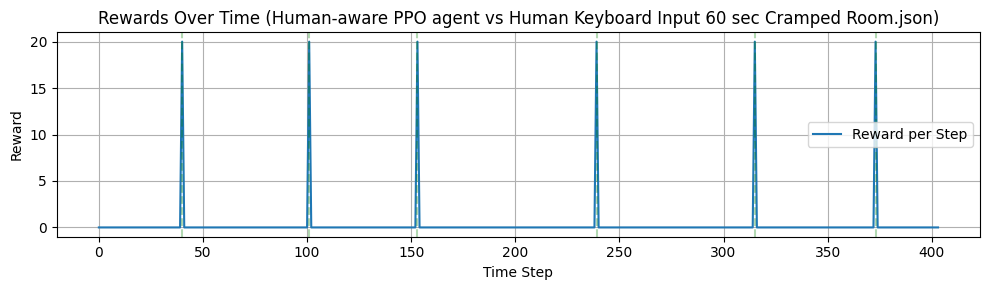


File: Human-aware PPO agent vs Human-aware PPO agent 60 sec Cramped Room.json
Episode Length: 404
Total Reward: 180
Soups Delivered: 9
INTERACT counts: Agent 0 = 91, Agent 1 = 96
Reward Events (time step, reward):
  - At step 38: +20
  - At step 73: +20
  - At step 118: +20
  - At step 157: +20
  - At step 200: +20
  - At step 238: +20
  - At step 273: +20
  - At step 319: +20
  - At step 364: +20


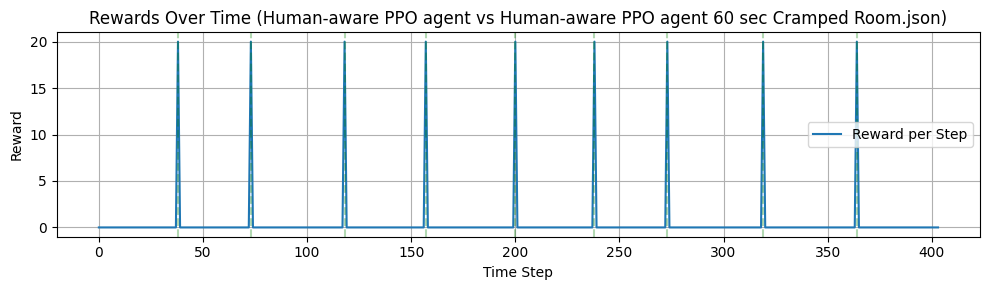


File: Population Based Training Agent vs Population Based Training Agent 60 sec Cramped Room.json
Episode Length: 404
Total Reward: 220
Soups Delivered: 11
INTERACT counts: Agent 0 = 98, Agent 1 = 81
Reward Events (time step, reward):
  - At step 39: +20
  - At step 74: +20
  - At step 108: +20
  - At step 144: +20
  - At step 179: +20
  - At step 213: +20
  - At step 247: +20
  - At step 281: +20
  - At step 315: +20
  - At step 351: +20
  - At step 385: +20


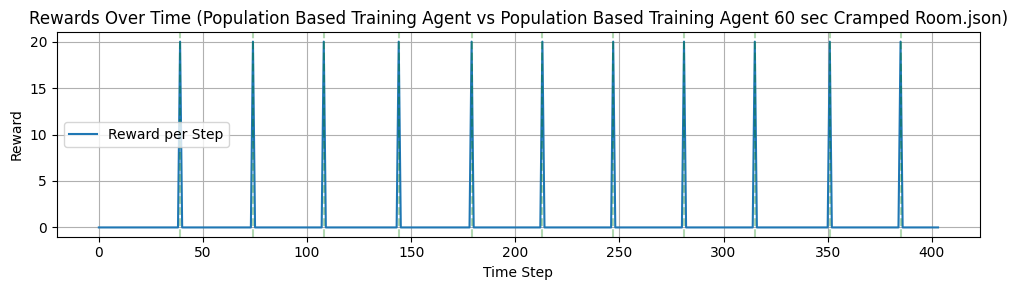


File: Population Based Training Agent vs Self-play agent Cramped Room.json
Episode Length: 404
Total Reward: 180
Soups Delivered: 9
INTERACT counts: Agent 0 = 68, Agent 1 = 134
Reward Events (time step, reward):
  - At step 48: +20
  - At step 85: +20
  - At step 134: +20
  - At step 166: +20
  - At step 209: +20
  - At step 269: +20
  - At step 305: +20
  - At step 344: +20
  - At step 380: +20


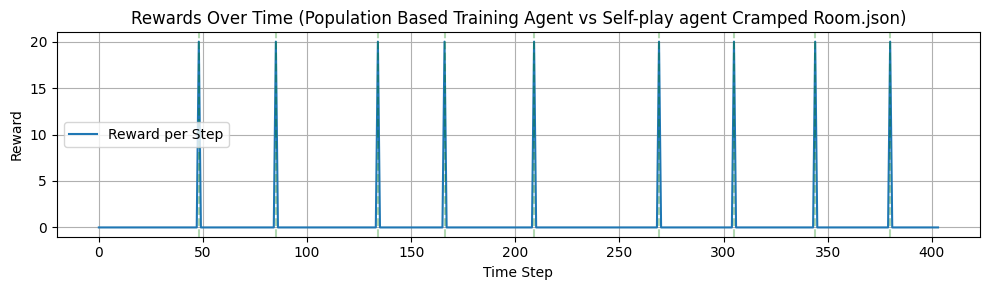


File: Population Based Training agent vs Human Keyboard Input 60 sec Cramped Room.json
Episode Length: 404
Total Reward: 140
Soups Delivered: 7
INTERACT counts: Agent 0 = 96, Agent 1 = 41
Reward Events (time step, reward):
  - At step 67: +20
  - At step 118: +20
  - At step 155: +20
  - At step 223: +20
  - At step 299: +20
  - At step 335: +20
  - At step 386: +20


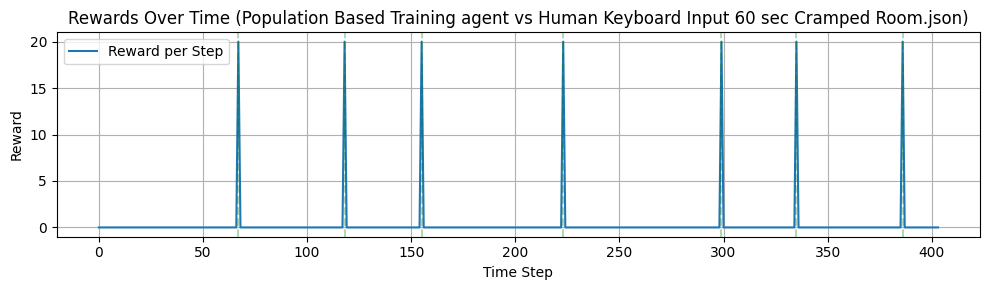


File: Population Based Training agent vs Human-aware PPO agent 60 sec Cramped Room.json
Episode Length: 404
Total Reward: 160
Soups Delivered: 8
INTERACT counts: Agent 0 = 104, Agent 1 = 154
Reward Events (time step, reward):
  - At step 85: +20
  - At step 157: +20
  - At step 192: +20
  - At step 229: +20
  - At step 263: +20
  - At step 304: +20
  - At step 341: +20
  - At step 385: +20


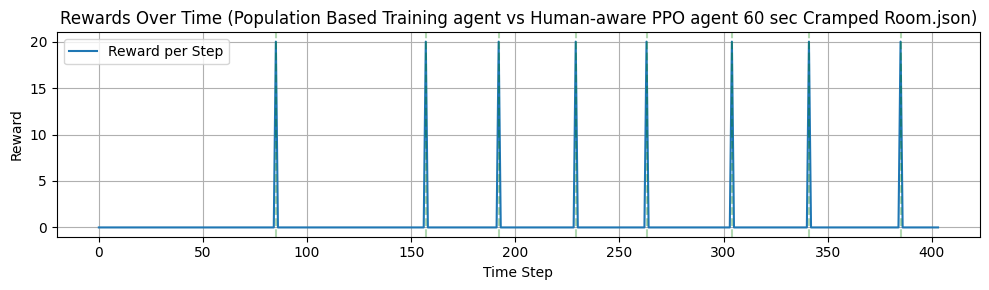


File: Self-Play agent vs Human-aware PPO agent 60 sec Cramped Room.json
Episode Length: 404
Total Reward: 180
Soups Delivered: 9
INTERACT counts: Agent 0 = 174, Agent 1 = 108
Reward Events (time step, reward):
  - At step 38: +20
  - At step 69: +20
  - At step 109: +20
  - At step 150: +20
  - At step 205: +20
  - At step 267: +20
  - At step 319: +20
  - At step 351: +20
  - At step 398: +20


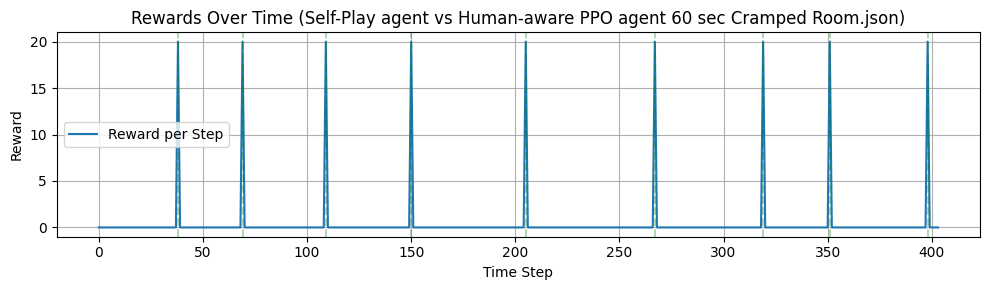


File: Self-play agent vs Human Keyboard Input 60 sec Cramped Room.json
Episode Length: 404
Total Reward: 120
Soups Delivered: 6
INTERACT counts: Agent 0 = 121, Agent 1 = 30
Reward Events (time step, reward):
  - At step 61: +20
  - At step 112: +20
  - At step 150: +20
  - At step 194: +20
  - At step 261: +20
  - At step 321: +20


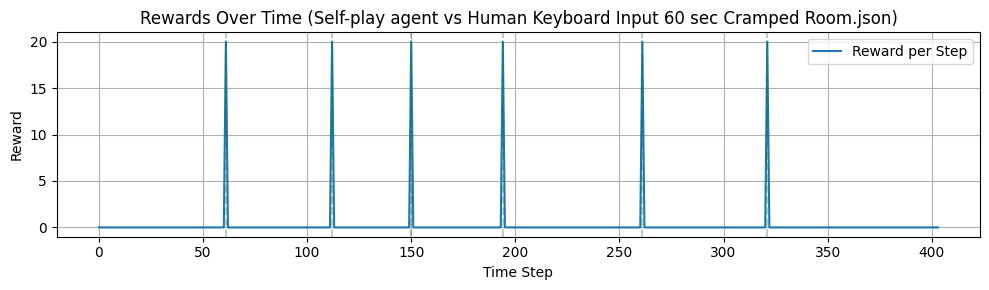


File: Self-play agent vs Self-play agent 60 sec Cramped Room.json
Episode Length: 404
Total Reward: 200
Soups Delivered: 10
INTERACT counts: Agent 0 = 171, Agent 1 = 164
Reward Events (time step, reward):
  - At step 40: +20
  - At step 71: +20
  - At step 108: +20
  - At step 141: +20
  - At step 203: +20
  - At step 235: +20
  - At step 271: +20
  - At step 306: +20
  - At step 339: +20
  - At step 380: +20


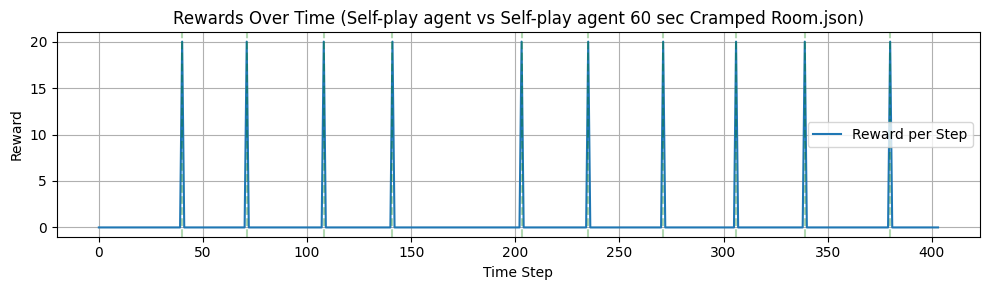

In [1]:
import os
import json
import matplotlib.pyplot as plt

def analyze_overcooked_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)

    observations = data['ep_observations'][0]
    actions = data['ep_actions'][0]
    rewards = data['ep_rewards'][0]

    total_reward = sum(rewards)
    episode_length = len(observations)
    soups_delivered = rewards.count(20)

    # Find timestamps when rewards were gained
    reward_events = [(i, r) for i, r in enumerate(rewards) if r > 0]

    interact_counts = [0, 0]
    for frame_actions in actions:
        for i, act in enumerate(frame_actions):
            if act == "INTERACT" or (isinstance(act, list) and "INTERACT" in act):
                interact_counts[i] += 1

    print(f"\nFile: {os.path.basename(filepath)}")
    print(f"Episode Length: {episode_length}")
    print(f"Total Reward: {total_reward}")
    print(f"Soups Delivered: {soups_delivered}")
    print(f"INTERACT counts: Agent 0 = {interact_counts[0]}, Agent 1 = {interact_counts[1]}")
    
    if reward_events:
        print("Reward Events (time step, reward):")
        for t, r in reward_events:
            print(f"  - At step {t}: +{r}")
    else:
        print("No rewards earned in this episode.")

    # Plot rewards and reward moments
    plt.figure(figsize=(10, 3))
    plt.plot(rewards, label='Reward per Step')
    for t, r in reward_events:
        plt.axvline(x=t, color='green', linestyle='--', alpha=0.3)
    plt.title(f"Rewards Over Time ({os.path.basename(filepath)})")
    plt.xlabel("Time Step")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Folder path
folder = "./Cramped_room"

# Analyze all JSON files in the folder
for filename in os.listdir(folder):
    if filename.endswith(".json"):
        analyze_overcooked_json(os.path.join(folder, filename))
